# Project 3: Web APIs & NLP

## Problem Statement

Use the Pushshift API to collect text data (posts) from two subreddits. After collecting the data, use NLP to train a classifier read analyze a post and determine/classify from which subreddit it came.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier #needed as default for AdaBoostClassifier
from sklearn.svm import SVC

import requests
import time

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Functions

In [2]:
def get_posts(sr, a_list, api_url):
    
    # get first batch 100
    params1 = {
        'subreddit': sr,
        'size': 100
    }
    ## submit request
    res1 = requests.get(api_url, params1)
    
    ## get request data in JSON format
    posts1 = res1.json()['data']
    
    # convert JSON data to dataframe
    df1 = pd.DataFrame(posts1)[['subreddit', 'title', 'selftext', 'created_utc']]
    
    # append dataframe to list
    a_list.append(df1)
    
    # get timestamp of last entry in dataframe
    # this is needed to make the next data request
    etime = df1['created_utc'].iloc[-1]
    
    # get remaining batches of 100 each
    # since we want approximately 5000 entries, 
    # we can use a for loop
    for _i in range(0, 75):
        params1 = {
            'subreddit': sr,
            'size': 100,
            'before': etime
        }

        res1 = requests.get(api_url, params1)
        posts1 = res1.json()['data']
        df1 = pd.DataFrame(posts1)[['subreddit', 'title', 'selftext', 'created_utc']]
        a_list.append(df1)
        etime = df1['created_utc'].iloc[-1]
        time.sleep(5)
    
    return a_list

In [3]:
def rm_spchars(x):
    
    x = str(x)
    
    # Tokenize
    # Instantiate RegExp Tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # Run Tokenizer. Tokenizer will return a list of strings.
    selftext_tokens = tokenizer.tokenize(x.lower())
    
    # Lemmantize
    # Instantiate Lemmantizer
    lemmatizer = WordNetLemmatizer()
    # Run Lemmantizer
    selftext_tokens_lem = [lemmatizer.lemmatize(i) for i in selftext_tokens]
    
    # Add stopwords
    stpwords = stopwords.words('english')
    newStopWords = ['ha','wa', 'like', 'new', '000', '2021', 'relate']
    stpwords.extend(newStopWords)
    
    # Remove stopwords from selftext_tokens
    selftext_tokens_no_stpwds = [token for token in selftext_tokens_lem if token not in stpwords]
    
    # combine the strings in selftext_tokens_no_stpwds
    x = ' '.join(selftext_tokens_no_stpwds)
    
    return x

In [4]:
def word_count(x):
    word_list = x.split()
    return len(word_list)

In [5]:
# Confusion Matrix
def get_confusion_matrix(reg_model, name, X_test, y_test):
    
    # Get test predictions
    y_preds = reg_model.predict(X_test)
    
    # Plot confusion matrix
    plot_confusion_matrix(reg_model, X_test, y_test, 
                          cmap='Blues', values_format='d', 
                          display_labels=['r/pennystocks', 'r/CryptoCurrency']);
    
    # Get Positives (T/F) and Negatives (T/F)
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    
    print('\033[1m' + 'True Negatives:' + '\033[0m')
    print('The', name, 'model has',  str(tn), 'true negatives.')
    print()
    print('\033[1m' + 'False Positives:' + '\033[0m')
    print('The', name, 'model has',  str(fp), 'false positives.')
    print()
    print('\033[1m' + 'False Negatives:' + '\033[0m')
    print('The', name, 'model has',  str(fn), 'false negatives.')
    print()
    print('\033[1m' + 'True Positives:' + '\033[0m')
    print('The', name , 'model has',  str(tp), 'true positives.')
    print()
    print('\033[1m' + 'Specificity:' + '\033[0m')
    print('Its specificity is', tn / (tn + fp))
    print()
    print('\033[1m' + 'Sensitivity:' + '\033[0m')
    print('Its sensitivity is', tp / (tp + fn))

### Variable

In [5]:
url = 'https://api.pushshift.io/reddit/search/submission'

### Data Collection

><div class="box">
<img src="./images/alert.gif" align="left" style="width: 16px; height: 16px"> 
<span style="line-height:16px;">&nbsp;The lines in this section have been greyed out, because the process to get the data is lengthy.  To avoid repeating the process, the data was saved to a csv file.</span>
</div>

- **Call function to retrieve subreddit posts**

In [6]:
# Get pennystocks subreddit posts
dfs_list = get_posts('pennystocks', [], url)

In [7]:
# Get CryptoCurrency subreddit posts
dfs_list = get_posts('CryptoCurrency', dfs_list, url)

- **Concatenate dataframes**

> The function `get_posts` returned a final list of dataframes `dfs_lists`. We can use `pd.concat()` to stack the dataframes vertically (`axis=0`).

In [9]:
# concatenate the dataframes, vertically 
sr_posts = pd.concat(dfs_list, axis=0)

In [10]:
sr_posts.shape

(15199, 4)

- **Export data to CSV**

In [11]:
sr_posts.to_csv('./data/sr_posts_dirty.csv')

### Data Cleaning

- **Load data**
><div class="box">
<img src="./images/alert.gif" align="left" style="width: 16px; height: 16px"> 
<span style="line-height:16px;">&nbsp;Added after commenting out `Data Collection` section.</span>
</div>

In [6]:
sr_posts = pd.read_csv('./data/sr_posts_dirty.csv')

- **Drop Unnamed: 0**
><div class="box">
<img src="./images/alert.gif" align="left" style="width: 16px; height: 16px"> 
<span style="line-height:16px;">&nbsp;Added after commenting out `Data Collection` section.</span>
</div>

In [7]:
sr_posts.drop(columns=['Unnamed: 0'], inplace=True)

- **Visually inspect the data**
> A quick visual inspection is needed get an idea of what is present (e.g., special characters, `NaNs`, etc).

In [8]:
sr_posts.head(10)

,subreddit,title,selftext,created_utc
0,pennystocks,$CRTD (Creatd) &lt;-- This One Has A LOT of Po...,"Doing some DD on $CRTD (Creatd), think this on...",1636133858
1,pennystocks,What is the optimal way to sell a penny stock?,Let’s say the daily volume of a penny stock is...,1636132558
2,pennystocks,"I will add it to my truffle pasta, when shiba 🚀🚀🚀",NaN,1636131673
3,pennystocks,I’m all in on $DBG.V and here’s why…,Doubleview Gold Corp is a junior mining compan...,1636129589
4,pennystocks,I am all in on DBG.V and here’s why…,Doubleview Gold Corp is a junior mining compan...,1636129479
5,pennystocks,$CLIS Announces Plans of Cryptocurrency and Bl...,NaN,1636128605
6,pennystocks,Gourmet Provisions International Corp. (GMPR) ...,[removed],1636128501
7,pennystocks,$BMRA - Holy naked shorts Batman! 3000x increa...,NaN,1636128420
8,pennystocks,"$WSGF - app launch in November, ticker change ...",NaN,1636127584
9,pennystocks,"$CLIS Exciting News! ""HeyPal(TM) Announces Pla...",NaN,1636127535


In [9]:
sr_posts.tail(10)

,subreddit,title,selftext,created_utc
15189,CryptoCurrency,Tell me your favorite one liner related to cry...,As experienced crypto investors you all are yo...,1635890888
15190,CryptoCurrency,NYC is now advertising meme coins…,NaN,1635890855
15191,CryptoCurrency,Checkout.com CEO says crypto ‘stablecoins’ cou...,NaN,1635890855
15192,CryptoCurrency,Ethiopia declares nationwide emergency as rebe...,NaN,1635890846
15193,CryptoCurrency,Australia's Largest Bank To Integrate Bitcoin ...,NaN,1635890837
15194,CryptoCurrency,Shill me your favorite one liner related to cr...,[removed],1635890814
15195,CryptoCurrency,Can you relate?,[removed],1635890793
15196,CryptoCurrency,$GARI Token,[removed],1635890748
15197,CryptoCurrency,10 Billion Hex Stakes Ending in 30 Days,NaN,1635890721
15198,CryptoCurrency,DogeBonk creators put up billboard in NYC. The...,NaN,1635890704


- **Check for null values**

In [10]:
sr_posts.isnull().sum()

subreddit         0
title             0
selftext       4736
created_utc       0
dtype: int64

In [11]:
sr_posts[sr_posts.isnull().any(axis=1)]

,subreddit,title,selftext,created_utc
2,pennystocks,"I will add it to my truffle pasta, when shiba 🚀🚀🚀",NaN,1636131673
5,pennystocks,$CLIS Announces Plans of Cryptocurrency and Bl...,NaN,1636128605
7,pennystocks,$BMRA - Holy naked shorts Batman! 3000x increa...,NaN,1636128420
8,pennystocks,"$WSGF - app launch in November, ticker change ...",NaN,1636127584
9,pennystocks,"$CLIS Exciting News! ""HeyPal(TM) Announces Pla...",NaN,1636127535
...,...,...,...,...
15191,CryptoCurrency,Checkout.com CEO says crypto ‘stablecoins’ cou...,NaN,1635890855
15192,CryptoCurrency,Ethiopia declares nationwide emergency as rebe...,NaN,1635890846
15193,CryptoCurrency,Australia's Largest Bank To Integrate Bitcoin ...,NaN,1635890837
15197,CryptoCurrency,10 Billion Hex Stakes Ending in 30 Days,NaN,1635890721


<span style="background-color:#ffff00;">**Notes:**</span>
> 1. Remove special characters from both `title` and `selftext` columns.
>
> 2. Instead of deleting rows where `selftext` is either `Nan`, `[removed]`, `[deleted]`, or `''`, lets fill those values with the title.  


- **Replace** `NaN` **with post's** `title`.

In [12]:
sr_posts['selftext'].fillna(sr_posts['title'], inplace=True)

In [13]:
sr_posts.isnull().sum()

subreddit      0
title          0
selftext       0
created_utc    0
dtype: int64

- **Remove links and line breaks from** the `selftext` **and** `title` **columns.**

In [14]:
for idx in ['selftext', 'title']:
    sr_posts[idx] = sr_posts[idx].replace(
        'http\S+', '', regex=True
    ).replace(
        'www\S+', '', regex=True
    ).replace(
        '\n\n\S+', '', regex=True
    ).replace(
        '\n|S+', '', regex = True
    )

- **Remove special characters from** the `selftext` **and** `title` **columns.**

In [15]:
for idx in ['selftext', 'title']:
    sr_posts[idx] = sr_posts[idx].apply(rm_spchars)

In [16]:
sr_posts.shape

(15199, 4)

In [17]:
sr_posts.head(10)

,subreddit,title,selftext,created_utc
0,pennystocks,crtd creatd lt one lot potential hort term man...,dd crtd creatd think one lot potential short t...,1636133858
1,pennystocks,optimal way sell penny stock,let say daily volume penny stock 250 million h...,1636132558
2,pennystocks,add truffle pasta shiba,add truffle pasta shiba,1636131673
3,pennystocks,dbg v,doubleview gold corp junior mining company cur...,1636129589
4,pennystocks,dbg v,doubleview gold corp junior mining company cur...,1636129479
5,pennystocks,cli announces plan cryptocurrency blockchain i...,cli announces plan cryptocurrency blockchain i...,1636128605
6,pennystocks,gourmet provision international corp gmpr anno...,removed,1636128501
7,pennystocks,bmra holy naked short batman 3000x increase vo...,bmra holy naked short batman 3000x increase vo...,1636128420
8,pennystocks,wgf app launch november ticker change coming s...,wgf app launch november ticker change coming s...,1636127584
9,pennystocks,cli exciting news heypal tm announces plan cry...,cli exciting news heypal tm announces plan cry...,1636127535


- **Replace** `removed`, `deleted`, **and** `''` **in** `selftext` **column with with post's** `title`.

In [52]:
for word in ['removed', 'deleted', '']:
    sr_posts['selftext'] = np.where(sr_posts['selftext'] == word, sr_posts['title'], sr_posts['selftext'])

In [19]:
sr_posts.head(10)

,subreddit,title,selftext,created_utc
0,pennystocks,crtd creatd lt one lot potential hort term man...,dd crtd creatd think one lot potential short t...,1636133858
1,pennystocks,optimal way sell penny stock,let say daily volume penny stock 250 million h...,1636132558
2,pennystocks,add truffle pasta shiba,add truffle pasta shiba,1636131673
3,pennystocks,dbg v,doubleview gold corp junior mining company cur...,1636129589
4,pennystocks,dbg v,doubleview gold corp junior mining company cur...,1636129479
5,pennystocks,cli announces plan cryptocurrency blockchain i...,cli announces plan cryptocurrency blockchain i...,1636128605
6,pennystocks,gourmet provision international corp gmpr anno...,gourmet provision international corp gmpr anno...,1636128501
7,pennystocks,bmra holy naked short batman 3000x increase vo...,bmra holy naked short batman 3000x increase vo...,1636128420
8,pennystocks,wgf app launch november ticker change coming s...,wgf app launch november ticker change coming s...,1636127584
9,pennystocks,cli exciting news heypal tm announces plan cry...,cli exciting news heypal tm announces plan cry...,1636127535


In [20]:
sr_posts.tail(10)

,subreddit,title,selftext,created_utc
15189,CryptoCurrency,tell favorite one liner related crypto,experienced crypto investor spent countless ho...,1635890888
15190,CryptoCurrency,nyc advertising meme coin,nyc advertising meme coin,1635890855
15191,CryptoCurrency,checkout com ceo say crypto stablecoins could ...,checkout com ceo say crypto stablecoins could ...,1635890855
15192,CryptoCurrency,ethiopia declares nationwide emergency rebel a...,ethiopia declares nationwide emergency rebel a...,1635890846
15193,CryptoCurrency,australia largest bank integrate bitcoin ervic...,australia largest bank integrate bitcoin ervic...,1635890837
15194,CryptoCurrency,hill favorite one liner related crypto,hill favorite one liner related crypto,1635890814
15195,CryptoCurrency,,,1635890793
15196,CryptoCurrency,gari token,gari token,1635890748
15197,CryptoCurrency,10 billion hex take ending 30 day,10 billion hex take ending 30 day,1635890721
15198,CryptoCurrency,dogebonk creator put billboard nyc meme coin a...,dogebonk creator put billboard nyc meme coin a...,1635890704


- **Drop** `title` **and** `created_utc` **columns**

In [21]:
sr_posts.drop(columns=['title', 'created_utc'], axis=1, inplace=True)

In [22]:
sr_posts.head()

,subreddit,selftext
0,pennystocks,dd crtd creatd think one lot potential short t...
1,pennystocks,let say daily volume penny stock 250 million h...
2,pennystocks,add truffle pasta shiba
3,pennystocks,doubleview gold corp junior mining company cur...
4,pennystocks,doubleview gold corp junior mining company cur...


- **Change** `subreddit` **categories to** `0` **(for** `pennystocks`**) and** `1` **(for** `CryptoCurrency`**)**

In [23]:
sr_posts['subreddit'] = sr_posts['subreddit'].map({'pennystocks': 0, 'CryptoCurrency': 1})

In [24]:
sr_posts

,subreddit,selftext
0,0,dd crtd creatd think one lot potential short t...
1,0,let say daily volume penny stock 250 million h...
2,0,add truffle pasta shiba
3,0,doubleview gold corp junior mining company cur...
4,0,doubleview gold corp junior mining company cur...
...,...,...
15194,1,hill favorite one liner related crypto
15195,1,
15196,1,gari token
15197,1,10 billion hex take ending 30 day


- **Catch any empty cells**
> Replace any empty cells with NaN, then drop those rows

In [25]:
# https://stackoverflow.com/questions/29314033/drop-rows-containing-empty-cells-from-a-pandas-dataframe
sr_posts['selftext'].replace('', np.nan, inplace=True)

In [26]:
sr_posts.isnull().sum()

subreddit     0
selftext     80
dtype: int64

In [27]:
sr_posts.dropna(subset=['selftext'], inplace=True)

In [28]:
sr_posts.isnull().sum()

subreddit    0
selftext     0
dtype: int64

- **Add word count column to dataframe**

In [29]:
sr_posts['post_word_count'] = sr_posts['selftext'].apply(word_count)

In [30]:
sr_posts.head(5)

,subreddit,selftext,post_word_count
0,0,dd crtd creatd think one lot potential short t...,158
1,0,let say daily volume penny stock 250 million h...,41
2,0,add truffle pasta shiba,4
3,0,doubleview gold corp junior mining company cur...,266
4,0,doubleview gold corp junior mining company cur...,266


In [31]:
sr_posts

,subreddit,selftext,post_word_count
0,0,dd crtd creatd think one lot potential short t...,158
1,0,let say daily volume penny stock 250 million h...,41
2,0,add truffle pasta shiba,4
3,0,doubleview gold corp junior mining company cur...,266
4,0,doubleview gold corp junior mining company cur...,266
...,...,...,...
15193,1,australia largest bank integrate bitcoin ervic...,7
15194,1,hill favorite one liner related crypto,6
15196,1,gari token,2
15197,1,10 billion hex take ending 30 day,7


- **Export data to CSV**

In [32]:
# sr_posts.to_csv('./data/sr_posts_clean.csv')

### EDA

- **Class balance**

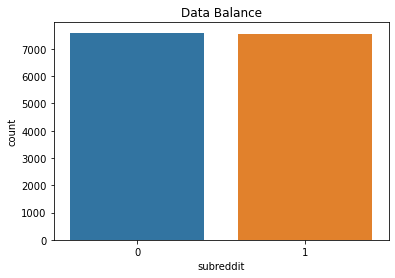

In [53]:
plt.title('Data Balance');
sns.countplot(data=sr_posts, x='subreddit');

- **Total number of words per subreddit**

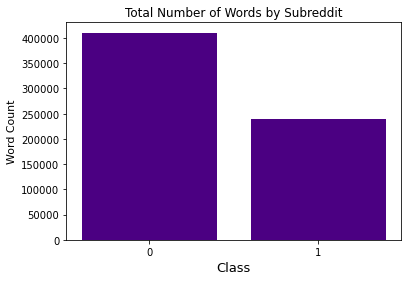

In [54]:
plt.title('Total Number of Words by Subreddit');
tot_words_per_sr = sr_posts.groupby('subreddit', as_index=False)[['post_word_count']].sum().rename(
    columns = {'post_word_count': 'total_words'}
)
tot_words_per_sr['subreddit'] = tot_words_per_sr['subreddit'].apply(lambda x: str(x))
plt.bar(x = tot_words_per_sr['subreddit'], height = tot_words_per_sr['total_words'], color = 'indigo')
plt.xlabel('Class', size = 13)
plt.ylabel('Word Count', size = 11);

In [55]:
tot_words_per_sr

,subreddit,total_words
0,0,410584
1,1,240303


The pennystock subreddit has 70% more words (410588) compared to the total number of words (240309) in the CryptoCurrency subreddit.

- **Fifteen (15) most commonly used words in pennystock subreddit**

In [36]:
# create dataframe where subreddit equals 0
penny = sr_posts[sr_posts['subreddit'] == 0]

In [37]:
# create series of words in pennystock subreddit
penny_words_s = penny['selftext']

# create CountVectorizer instance 
cvec_penny = CountVectorizer(stop_words='english')

# transform penny_words_s
penny_words_cv = cvec_penny.fit_transform(penny_words_s)

# convert penny_words_cv to dataframe so words can be counted
penny_words_df = pd.DataFrame(penny_words_cv.todense(), columns=cvec_penny.get_feature_names())

penny_words_df

,00,0000,0000000000001,00000000001,000001,00005,0000908259,0000s,0001,0001334831,...,zuki,zulu,zuo,zuora,zvv,zynerba,în,α7,α7nachr,ﬁt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


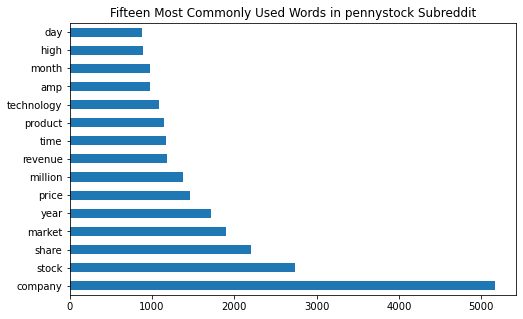

In [38]:
plt.title('Fifteen Most Commonly Used Words in pennystock Subreddit');
penny_words_df.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8,5));

- **Fifteen (15) most commonly used words in CryptoCurrency subreddit**

In [39]:
# create dataframe where subreddit equals 1
crypt = sr_posts[sr_posts['subreddit'] == 1]

In [40]:
# create series of words in CryptoCurreny subreddit
crypt_words_s = crypt['selftext']

# create CountVectorizer instance 
cvec_crypt = CountVectorizer(stop_words='english')

# transform crypt_words_s
crypt_words_cv = cvec_crypt.fit_transform(crypt_words_s)

# convert crypt_words_cv to dataframe so words can be counted
crypt_words_df = pd.DataFrame(crypt_words_cv.todense(), columns=cvec_crypt.get_feature_names())

crypt_words_df

,00,0000,000000001,000000007263,00000001,00000002284,0000000fuckall,0000001,000000131183,00000015,...,用戶增長和交易量等可衡量的指標,算力通證已成長為行業內最前沿,算力通證為我們帶來的各種專案優勢,算力通證的成功不是一蹴而就的,算力通證顯然是2020年以來行業內最大的成功案例之一,通過算力規模,鱿鱼币狂飙数千倍后崩盘的几个看点,龙头细分,𝑺𝒖𝒑𝒆𝒓𝑨𝒊𝒓𝒅𝒓𝒐𝒑,𝙗𝙤𝙩𝙝
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


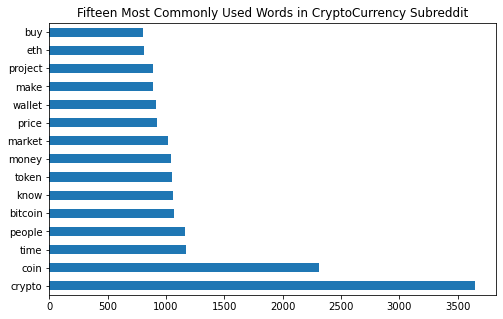

In [41]:
plt.title('Fifteen Most Commonly Used Words in CryptoCurrency Subreddit');
crypt_words_df.sum().sort_values(ascending = False).head(15).plot(kind='barh', figsize=(8,5));

### Build First Model-- Naïve Bayes

- **Create feature series** `X`, **and target** `y`.

In [42]:
X = sr_posts['selftext']
y = sr_posts['subreddit']

- **Split dataset into training and test**

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    stratify=y, 
                                                    random_state=42)

- **Create a pipeline to hold both the transformer** `CountVectorizer` **and the estimator** `MultinomialNB`.

In [44]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), #stop_words removes stop words and mitigates overfitting
    ('mnb', MultinomialNB())
])

- **Create pipe parameters to tune the** `CountVectorizer`.

In [45]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 4, 6],
    'cvec__max_df': [.85, .9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)]
}

- **Instantiate** `GridSearchCV`.

In [46]:
gs = GridSearchCV(pipe, pipe_params, cv = 5)

- **Fit GridSearch to the training data**

In [47]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 4, 6],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [58]:
gs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 5000,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 1)}

- **Get the training and test accuracy scores**

In [60]:
print(f'The training score is: \t{round(gs.score(X_train, y_train),2)}')
print(f'The test score is: \t{round(gs.score(X_test, y_test),2)}')

The training score is: 	0.88
The test score is: 	0.86


- **Additional Metrics**

True Negatives:
The Naïve Bayes model has 2013 true negatives.

False Positives:
The Naïve Bayes model has 492 false positives.

False Negatives:
The Naïve Bayes model has 188 false negatives.

True Positives:
The Naïve Bayes model has 2297 true positives.

Specificity:
Its specificity is 0.8035928143712575

Sensitivity:
Its sensitivity is 0.9243460764587526


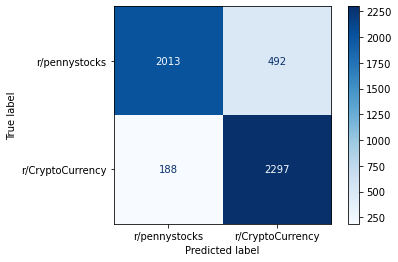

In [122]:
get_confusion_matrix(gs, 'Naïve Bayes', X_test, y_test)

## Build Second Model-- Random Forest

Here, we can reuse `X`, `y`, `X_train`, and `y_train`, no need to recreate those variables, because they haven't been modified.

- **Create CountVectorizer instance**

In [123]:
cvec = CountVectorizer(stop_words='english')

- **Fit and transfrom** `X_train`, **and transform** `X_test` **for the vectorizer**

In [124]:
Xcvec_train = cvec.fit_transform(X_train)
Xcvec_test = cvec.transform(X_test)

- **Create Random Tree Classifier model**

In [125]:
rfc = RandomForestClassifier()

- **Create tuning parameters for Random Tree classifier**

In [126]:
params = {
    'n_estimators': [750, 1000],
    'max_depth': [17, 19],
    'min_samples_split': [4, 5],
    'min_samples_leaf': [2, 3],
    'max_features': ['auto']
}

- **Create GridSearch instance**

In [127]:
gs = GridSearchCV(rfc, params, cv = 5)

- **Fit the GridSearch instance**

In [128]:
gs.fit(Xcvec_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [17, 19], 'max_features': ['auto'],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [4, 5],
                         'n_estimators': [750, 1000]})

- **Score the Random Tree Model**

In [129]:
print('The training score is:', gs.score(Xcvec_train, y_train))
print('The test score is:', gs.score(Xcvec_test, y_test))

The training score is: 0.8523052621186692
The test score is: 0.845691382765531


- **Additional Metrics**

True Negatives:
The Random Forest model has 1862 true negatives.

False Positives:
The Random Forest model has 643 false positives.

False Negatives:
The Random Forest model has 127 false negatives.

True Positives:
The Random Forest model has 2358 true positives.

Specificity:
Its specificity is 0.743313373253493

Sensitivity:
Its sensitivity is 0.9488933601609658


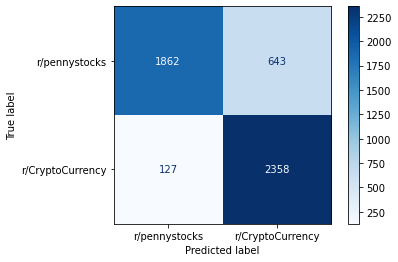

In [132]:
get_confusion_matrix(gs, 'Random Forest', Xcvec_test, y_test)

## Build Third Model-- SVM

Here, we can reuse `cvec`, `Xcvec_train`, `Xcvec_test`, `y_train`, and `y_test`

- **Create svm instance**

In [133]:
svc = SVC()

- **Use** `GridSearchCV` **to find best parameters**

In [134]:
# SVC paramenters
params_grid = {
    'C': [0.5, 1.0, 1.5, 2.0],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [1, 2, 3],
    'gamma': ['scale', 'auto']
}

- **Create GridSearch instance**

In [135]:
# Create GridSearchCV object
gs = GridSearchCV(svc, params_grid)

- **Fit GridSearch instance**

In [136]:
# Fit GridSearch object to training data
gs.fit(Xcvec_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.5, 1.0, 1.5, 2.0], 'degree': [1, 2, 3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']})

- **Evaluate SVC**

In [137]:
print('The training score is:', gs.score(Xcvec_train, y_train))
print('The test score is:', gs.score(Xcvec_test, y_test))

The training score is: 0.9809457991904433
The test score is: 0.8965931863727455


- **Additional SVC Metrics**

True Negatives:
The SVC model has 2276 true negatives.

False Positives:
The SVC model has 229 false positives.

False Negatives:
The SVC model has 287 false negatives.

True Positives:
The SVC model has 2198 true positives.

Specificity:
Its specificity is 0.9085828343313374

Sensitivity:
Its sensitivity is 0.8845070422535212


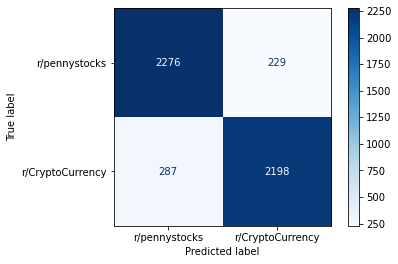

In [138]:
get_confusion_matrix(gs, 'SVC', Xcvec_test, y_test)

## Build Fourth Model-- AdaBoost

- **Create AdaBoost instance**

In [139]:
# Instantiate AdaBoost Classifier
ada = AdaBoostClassifier()

- **Establish a list of values for n_estimators parameter**

In [140]:
# Set AdaBoost Parameters
ada_params = {
    'n_estimators': [50, 100, 150]
}

- **Instantiate GridSearchCV**

In [141]:
gs_ada = GridSearchCV(ada, ada_params)

- **Fit GridSearchCV Instance**

In [142]:
# Fit gs_ada
gs_ada.fit(Xcvec_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [50, 100, 150]})

- **Evaluate AdaBoost Model**

In [325]:
# Evaluate ADA
print('The training score is:', gs_ada.score(Xcvec_train, y_train))
print('The test score is:', gs_ada.score(Xcvec_test, y_test))

The training score is: 0.8789166749036276
The test score is: 0.8633353401565322


- **Additional Metrics**

True Negatives:
The AdaBoost model has 2392 true negatives.

False Positives:
The AdaBoost model has 113 false positives.

False Negatives:
The AdaBoost model has 622 false negatives.

True Positives:
The AdaBoost model has 1863 true positives.

Specificity:
Its specificity is 0.9548902195608783

Sensitivity:
Its sensitivity is 0.7496981891348089


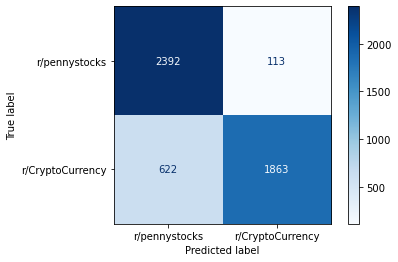

In [144]:
get_confusion_matrix(gs_ada, 'AdaBoost', Xcvec_test, y_test)

### Conclusion

> - The all models could have performed better if more attention were given to eliminating stop-like words.
>
> - An increase in the number of observations improved the scores of all models.  Initially, a sample size of 4000 observations were collected.  The scores improved after the sample size was increased to 15,000 observations.
>
> - Finding the best hyperparameters is dependent on time and compute resources, and can lead to improved model performance.